In [1]:
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pylab import cm as cmaps
from pylab import rcParams
import healpy as hp
from tqdm import *
from astropy import units as u
from scipy.ndimage.filters import gaussian_filter

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from plot_params import params
from simulation.astrometry_sim import QuasarSim
from theory.units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [217]:
# pylab.rcParams.update(params)
# plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
# plots_dir = "/Users/smsharma/Desktop/LensPower_Offline/plots/"

# data_dir = "/Users/smsharma/QuasarSims/"

In [222]:
for i,it in tqdm(enumerate([4,5,6]), total=3):
    print(i,it)

100%|██████████| 3/3 [00:00<00:00, 6928.92it/s]

0 4
1 5
2 6


In [256]:
max_sep = 25
nside = 64
lmax = 3 * nside - 1

sim = QuasarSim(max_sep=max_sep, 
                verbose=True,
                sim_uniform=True, 
                nside=nside, 
                calc_powerspecs=False, 
                do_alpha=False,
                sh_profile='NFW')

sim.set_mass_distribution(sim.rho_M_SI, M_min=1e7 * M_s, M_max=1e10 * M_s, M_min_calib=1e8 * M_s, M_max_calib=1.1e10 * M_s, N_calib=4., alpha=-1.9)
sim.set_radial_distribution(sim.r2rho_V_ein_EAQ, R_min=1e-3 * kpc, R_max=260 * kpc)
sim.set_subhalo_properties(sim.c200_SCP, distdep=False)

Simulating 37 subhalos between 7.0 and 10.0


In [257]:
sim.analysis_pipeline(get_sample=True)

In [258]:
sim.mu_qsrs.shape

(49152, 2)

/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/smsharma/anaconda3/envs/sbi-fermi/lib/python3.6/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds


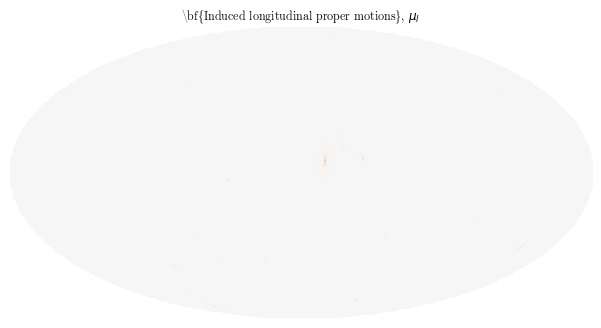

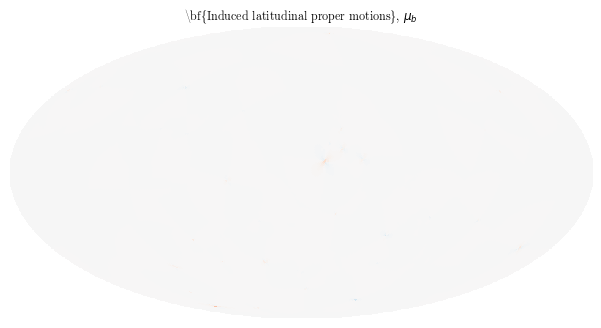

In [259]:
max_mu = 8e-4 / 0.6e-4
cmap = cmaps.RdBu_r
cmap.set_under('w')

hp.mollview(1e6 * sim.mu_qsrs[:,0] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced longitudinal proper motions}, $\mu_l$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)
hp.mollview(1e6 * sim.mu_qsrs[:,1] / 1e-4,max=max_mu, min=-max_mu, title=r"\bf{Induced latitudinal proper motions}, $\mu_b$", unit='$\mu$as\,yr$^{-1}$', cmap=cmap, cbar=None)

In [260]:
import sys
sys.path.append("../")

from models.embedding import SphericalGraphCNN

In [261]:
nside_list = [64, 32, 16, 8, 4, 2, 1]

In [262]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, mask_ring = False)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])


In [263]:
in_map[0].shape

torch.Size([49152, 2])

In [264]:
import torch
in_map = torch.Tensor((sim.mu_qsrs.reshape((1, -1, 2))))
in_map.shape

torch.Size([1, 49152, 2])

In [265]:
log_mean = torch.log(torch.mean(in_map, axis=1))
log_std = torch.log(torch.var(in_map, axis=1).sqrt())

log_mean = log_mean.reshape((1, -1, 2))
log_std = log_std.reshape((1, -1, 2))

data_map = torch.cat([in_map], axis=1)
data_map.shape

torch.Size([1, 49152, 2])

In [266]:
data_map = data_map.view(-1, 2, 49152)

In [267]:
sg = SphericalGraphCNN(nside_list, indexes_list, in_ch=2)

In [268]:
data_map = torch.cat(4 * [data_map])

In [269]:
data_map.shape

torch.Size([4, 2, 49152])

In [270]:
theta = torch.ones([4, 1000])

In [271]:
sg(data_map, theta).shape

torch.Size([4, 32])